<a href="https://colab.research.google.com/github/AncaIoanaMuscalagiu/ProteinFoldingNotebooks/blob/main/Working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
# import torchvision  # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
from torch import nn  # All neural network modules
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class RNN_LSTM_onlyLastHidden(nn.Module):
    """
    LSTM version that just uses the information from the last hidden state
    since the last hidden state has information from all previous states
    basis for BiDirectional LSTM
    """
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM_onlyLastHidden, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # change basic RNN to LSTM
        # num_layers Default: 1
        # bias Default: True
        # batch_first Default: False
        # dropout Default: 0
        # bidirectional Default: False
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # remove the sequence_length
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Get data to cuda if possible
        x = x.to(device)
        # print("input x.size() = ", x.size())
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # LSTM needs a separate cell state (LSTM needs both hidden and cell state)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Forward propagate LSTM
        # need to give LSTM both hidden and cell state (h0, c0)
        out, _ = self.lstm(
            x, (h0, c0)
        )  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        # no need to reshape the out or concat
        # out is going to take all mini-batches at the same time + last layer + all features
        out = self.fc(out[:, -1, :])
        # print("forward out = ", out)
        return out

    def sample_action(self, obs, epsilon):
        # print("Sample Action called+++")
        """
        greedy epsilon choose
        """
        coin = random.random()
        if coin < epsilon:
            # print("coin < epsilon", coin, epsilon)
            # for 3actionStateEnv use [0,1,2]
            explore_action = random.randint(0,2)
            # print("explore_action = ", explore_action)
            return explore_action
        else:
            # print("exploit")
            out = self.forward(obs)
            return out.argmax().item()



In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import os # for creating directories
import sys
import datetime

# time the program
from time import time


In [5]:
seq = "HHPPHH"
seed = 42
num_episodes = 10000
algo = "50mer-DQN-Seed42-600K"
use_early_stop = 0


In [6]:

base_dir = f"./{datetime.datetime.now().strftime('%m%d-%H%M')}-"
# construct subdir with seq and seed
config_str = f"{seq[:6]}-{algo}-seed{seed}-{num_episodes}epi"
save_path = base_dir + config_str + "/"

# whether to show or save the matplotlib plots
display_mode = "show"  # save for CMD, show for ipynb
if display_mode == "save":
    save_fig = True
else:
    save_fig = False



In [7]:
import numpy as np

max_steps_per_episode = len(seq)

learning_rate = 0.0005

mem_start_train = max_steps_per_episode * 50  # for memory.size() start training
TARGET_UPDATE = 100  # fix to 100

# capped at 50,000 for <=48mer
buffer_limit = int(min(50000, num_episodes // 10))  # replay-buffer size

# Exploration parameters
max_exploration_rate = 1
min_exploration_rate = 0.01

# render settings
show_every = num_episodes // 1000  # for plot_print_rewards_stats
pause_t = 0.0
# metric for evaluation
rewards_all_episodes = np.zeros(
    (num_episodes,),
    # dtype=np.int32
)
reward_max = 0
# keep track of trapped SAW
num_trapped = 0
# early_stopped
num_early_stopped = 0

warmRestart = True
decay_mode = "exponential"  # exponential, cosine, linear
num_restarts = 1  # for cosine decay warmRestart=True
exploration_decay_rate = 5  # for exponential decay
start_decay = 0  # for exponential and linear
print(f"decay_mode={decay_mode} warmRestart={warmRestart}")
print(f"num_restarts={num_restarts} exploration_decay_rate={exploration_decay_rate} start_decay={start_decay}")


decay_mode=exponential warmRestart=True
num_restarts=1 exploration_decay_rate=5 start_decay=0


In [8]:
import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)



def ExponentialDecay(episode, num_episodes,
                min_exploration_rate, max_exploration_rate,
                exploration_decay_rate=5,
                start_decay=0):
    decay_duration = num_episodes - start_decay
    exploration_rate = max_exploration_rate
    if episode > start_decay:
        exploration_rate = min_exploration_rate + \
            (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*(episode-start_decay)/decay_duration)
    return exploration_rate

def LinearDecay(episode, num_episodes,
                min_exploration_rate, max_exploration_rate,
                start_decay=0):
    decay_duration = num_episodes - start_decay
    exploration_rate = max_exploration_rate
    if episode > start_decay:
        exploration_rate = min_exploration_rate + \
                            (decay_duration-(episode-start_decay))/decay_duration
        # print("(decay_duration-(episode-start_decay))/decay_duration = ", (decay_duration-(episode-start_decay))/decay_duration)
    # print("exploration_rate = ", exploration_rate)
    return exploration_rate


def Plot_Anneal_Schedule(num_episodes, eta_min=0.01, eta_max=1.0, mode="save", save_path="", warmRestart=True,
                         decay_mode="cosine",
                         num_restarts=10,
                         exploration_decay_rate=5,
                         start_decay=0):
    print("warmRestart = ", warmRestart)
    # Exploration parameters
    max_exploration_rate = eta_max
    min_exploration_rate = eta_min

    y =np.zeros(
        (num_episodes,),
    )

    if decay_mode == "exponential":
        for n_episode in range(num_episodes):
            y[n_episode] = ExponentialDecay(
                n_episode,
                num_episodes,
                min_exploration_rate,
                max_exploration_rate,
                exploration_decay_rate=exploration_decay_rate,
                start_decay=start_decay,
            )
    elif decay_mode == "linear":
        for n_episode in range(num_episodes):
            y[n_episode] = LinearDecay(
                n_episode,
                num_episodes,
                min_exploration_rate,
                max_exploration_rate,
                start_decay=start_decay,
            )

    fig, ax = plt.subplots()

    plt.yticks(np.arange(-.1, 1.1, 0.1))

    ax.plot(np.arange(num_episodes), y)
    ax.set(xlabel='Episode', ylabel='epsilon',
        # title=f'Epsilon Decay with {decay_mode}Decay warmRestart={warmRestart}')
        title=f'Epsilon Decay with {decay_mode}Decay')
    ax.grid()

    plt.show()
    plt.close()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)


def plot_moving_avg(scores, n=500, mode="show", save_path=""):
    print("means = ", scores.mean())

    # useful utility function for graphing the average
    def moving_average(a, n=n):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    plt.plot(moving_average(scores, n=n))
    # plt.plot(moving_average(opt_scores, n=500))
    # plt.plot(moving_average(rand_scores, n=500))
    if mode == "show":
        plt.show()
    elif mode == "save":
        # save the pdf fig with seq name
        plt.savefig(save_path + "moving_avg-" + str(n) + ".png")
    plt.close()


def log_rewards_frequency(rewards_all_episodes):
    # review all episodes' rewards
    print("$$$ rewards_all_episodes: ", rewards_all_episodes)
    print("$$$ rewards_all_episodes last 10 rewards = ",
          rewards_all_episodes[-10:])
    # count the frequency of unique rewards
    unique_elements, counts_elements = np.unique(
                                            rewards_all_episodes,
                                            return_counts=True)
    print("Frequency of unique rewards of rewards_all_episodes:")
    with np.printoptions(suppress=True):
        print(np.asarray((unique_elements, counts_elements)))


def plot_rewards_histogram(rewards_all_episodes, mode="show", save_path="", config_str=""):
    # plot the histogram of rewards_all_episodes
    # number of bins derived from https://stackoverflow.com/questions/30112420/histogram-for-discrete-values-with-matplotlib
    data = rewards_all_episodes
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2

    # Width, height in inches.
    # default: [6.4, 4.8]
    fig_width = 6.4
    fig_height = 4.8
    # adjust the height of the histogram
    if right_of_last_bin - left_of_first_bin > 10:
        fig_width = 8
        fig_height = 5
    elif right_of_last_bin - left_of_first_bin > 20:
        fig_width = 12
        fig_height = 6
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # the histogram of the data
    n, bins, patches = ax.hist(
        data,
        np.arange(left_of_first_bin, right_of_last_bin + d, d),
        density=True,
        facecolor='g',
    )

    # Make a plot with major ticks that are multiples of 20 and minor ticks that
    # are multiples of 5.  Label major ticks with '.0f' formatting but don't label
    # minor ticks.  The string is used directly, the `StrMethodFormatter` is
    # created automatically.
    if right_of_last_bin - left_of_first_bin > 20:
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(1))  # multiple of 1
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))

    # For the minor ticks, use no labels; default NullFormatter.
    ax.xaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlabel('Rewards')
    ax.set_ylabel('Frequency (Num of Episodes)')
    ax.set_title(f'Histogram of Rewards: {config_str}')

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.grid(True)
    if mode == "show":
        plt.show()
    elif mode == "save":
        # save the pdf fig with seq name
        plt.savefig(save_path+"rewards_histogram.png")
    plt.close()


def plot_print_rewards_stats(rewards_all_episodes,
                             show_every,
                             mode="show",
                             save_path=""):
    # unpack the args
    seq = "HHPPHH"
    seed = 42
    algo = "ALG0"
    num_episodes = 10000

    # Calculate and print the average reward per show_every episodes
    rewards_per_N_episodes = np.split(
                                np.array(rewards_all_episodes),
                                num_episodes/show_every
                            )
    count = show_every

    # for plotting
    aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

    print("\n********Stats per {} episodes********\n".format(show_every))
    for r in rewards_per_N_episodes:
        # print(count, "avg: ", str(sum(r/show_every)))
        # print(count, "min: ", str(min(r)))
        # print(count, "max: ", str(max(r)))

        aggr_ep_rewards['ep'].append(count)
        aggr_ep_rewards['avg'].append(sum(r/show_every))
        aggr_ep_rewards['min'].append(min(r))
        aggr_ep_rewards['max'].append(max(r))

        count += show_every

    # Width, height in inches.
    # default: [6.4, 4.8]
    fig_width = 6.4
    fig_height = 4.8
    # adjust the height of the histogram
    if np.array(rewards_all_episodes).max() - np.array(rewards_all_episodes).min() > 10:
        fig_width = 6.5
        fig_height = 6.5
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    # Be sure to only pick integer tick locations
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(1))

    ax.set_xlabel('Episode Index')
    ax.set_ylabel('Episode Reward')

    ax.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
    ax.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
    ax.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=3)

    # split the seq into chunks of 10 for the matplotlib title
    chunks, chunk_size = len(seq), 10
    seq_title_list = [
        seq[i:i+chunk_size]+"\n" for i in range(0, chunks, chunk_size)
    ]
    seq_title_str = ''.join(seq_title_list)
    title = "{}Algo={}, Epi={}, Seed={}\nShow-every {}".format(
        seq_title_str,
        algo,
        num_episodes,
        seed,
        show_every,
    )
    # print("Title: ", title)
    plt.title(title)
    plt.grid(True, which="major", lw=1.2, linestyle='-')
    plt.grid(True, which="minor", lw=0.8, linestyle='--')
    plt.tight_layout()
    if mode == "show":
        plt.show()
    elif mode == "save":
        # save the pdf fig with seq name
        plt.savefig("{}Seq_{}-{}-Eps{}-Seed{}.png".format(
            save_path,  # "./xxx"
            seq,
            algo,
            num_episodes,
            seed,
        ))
    plt.close()


def extract_max_per_chunk(rewards_all_episodes,
                          num_episodes,
                          show_every):
    """
    extract the max per chunk
    """
    rewards_per_N_episodes = np.split(
                                rewards_all_episodes,
                                num_episodes//show_every
                            )
    aggr_max = np.zeros((num_episodes//show_every,))

    for index, r in enumerate(rewards_per_N_episodes):
        aggr_max[index] = np.amax(r)

    return aggr_max

def avg_std_of_max(seed_42_data,
                   seed_1984_data,
                   seed_1991_data,
                   seed_2021_data,
                   num_episodes,
                   N_chunks,
                   show_every,
                   ):
    max_seed_42_data = extract_max_per_chunk(seed_42_data,
                                            num_episodes,
                                            show_every)
    max_seed_1984_data = extract_max_per_chunk(seed_1984_data,
                                            num_episodes,
                                            show_every)
    max_seed_1991_data = extract_max_per_chunk(seed_1991_data,
                                            num_episodes,
                                            show_every)
    max_seed_2021_data = extract_max_per_chunk(seed_2021_data,
                                            num_episodes,
                                            show_every)

    print("max_data shape = ", max_seed_42_data.shape, max_seed_2021_data.shape)

    num_seeds = 4
    max_stacked = np.zeros((num_seeds, N_chunks))

    max_stacked[0] = max_seed_42_data
    max_stacked[1] = max_seed_1984_data
    max_stacked[2] = max_seed_1991_data
    max_stacked[3] = max_seed_2021_data

    avg = np.mean(max_stacked, axis=0)
    std = np.std(max_stacked, axis=0)

    # print("avg = ", avg)
    # print("std = ", std)

    return avg, std

def plot_shaded_std(title, N_chunks, show_every, mean_1, std_1, mean_2, std_2,
                    mean_3=None, std_3=None):
    # import seaborn as sns
    # sns.set()

    import matplotlib.pyplot as plt

    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=24)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=21)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=21)    # fontsize of the tick labels
    plt.rc('legend', fontsize=15)    # legend fontsize
    # plt.rc('figure', titlesize=48)  # fontsize of the figure title
    plt.rcParams["figure.figsize"] = (8, 7)
    # plt.rcParams["font.family"] = "monospace"

    x = np.arange(N_chunks)
    x = x*show_every
    x = x // 1000  # per K
    # print(x)

    # plot
    fig, ax = plt.subplots()

    ax.plot(x, mean_1, color='b', label='RAND')
    ax.fill_between(x, mean_1 - std_1, mean_1 + std_1, color='b', alpha=0.2)
    ax.plot(x, mean_2, color='r', label='DQN-LSTM')
    # ax.plot(x, mean_2, color='r', label='DQN+Pruning+TrapPenalty')
    ax.fill_between(x, mean_2 - std_2, mean_2 + std_2, color='r', alpha=0.2)
    ax.plot(x, mean_3, color='y', label='DQN-FCN')
    # ax.plot(x, mean_3, color='y', label='DQN w/o Pruning/TrapPenalty')
    ax.fill_between(x, mean_3 - std_3, mean_3 + std_3, color='y', alpha=0.2)

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}k"))

    # optional: set the y limit
    # ax.set_ylim(-20, -9)

    ax.set_xlabel("Episode Index")
    ax.set_ylabel("Energy")
    ax.legend(loc='lower left')
    # ax.legend(loc='upper right')
    ax.set_title(title, fontsize=27)

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.savefig(title + "-RANDvsDQN.png")
    plt.show()
    plt.close()


In [12]:
# this is a Deep Q Learning (DQN) agent including replay memory and a target network
# you can write a brief 8-10 line abstract detailing your submission and experiments here
# the cod is based on https://github.com/seungeunrho/minimalRL/blob/master/dqn.py, which is released under the MIT licesne
# make sure you reference any cod you have studied as above, with one comment line per reference

# imports
from collections import deque
# Note: deque is pronounced as “deck.” The name stands for double-ended queue.
import random
import pickle
# pytorch deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# hyperparameters
gamma = 0.98    # discount rate
batch_size = 32
train_times = 10  # number of times train was run in a loop


class ReplayBuffer():
    """
    for DQN (off-policy RL), big buffer of experience
    you don't update weights of the NN as you run
    through the environment, instead you save
    your experience of the environment to this ReplayBuffer
    It has a max-size to fit in certain examples
    """
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            # a tuple that tells us what the state was
            # at a particular point in time
            # we store the current state, the action we chose,
            # the state we ended up in, and whether finished or not
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        # converting the list to a single numpy.ndarray with numpy.array()
        # before converting to a tensor
        s_lst = np.array(s_lst)
        a_lst = np.array(a_lst)
        r_lst = np.array(r_lst)
        s_prime_lst = np.array(s_prime_lst)
        done_mask_lst = np.array(done_mask_lst)

        # print("torch.tensor(s_lst, dtype=torch.float) = ", torch.tensor(s_lst, dtype=torch.float))
        # print("torch.tensor(a_lst) = ", torch.tensor(a_lst))
        # print("torch.tensor(r_lst) = ", torch.tensor(r_lst))
        # print("torch.tensor(s_prime_lst, dtype=torch.float) = ", torch.tensor(s_prime_lst, dtype=torch.float))
        # print("torch.tensor(done_mask_lst) = ", torch.tensor(done_mask_lst))

        return torch.tensor(s_lst, device=device, dtype=torch.float), torch.tensor(a_lst, device=device), \
               torch.tensor(r_lst, device=device), torch.tensor(s_prime_lst, device=device, dtype=torch.float), \
               torch.tensor(done_mask_lst, device=device)

    def size(self):
        return len(self.buffer)

    def save(self, save_path):
        """save in .pkl file"""
        with open(save_path, 'wb') as handle:
            pickle.dump(self.buffer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    def load(self, file_path):
        """load a .pkl file"""
        with open(file_path, 'rb') as handle:
            self.buffer = pickle.load(handle)

class FCN_QNet(nn.Module):
    """
    action value function, Q(S, a)
    produce the actions in parallel as output vector,
    and choose the max
    """
    def __init__(self, insize, outsize):
        """
        insize ==> input size
            == size of the observation space
        outsize ==> output size
            == number of actions
        """
        super(FCN_QNet, self).__init__()
        self.fc1 = nn.Linear(insize, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, outsize)

    def forward(self, x):
        """
        standard 3-layer fully connected NN
        """
        x = x.to(device)  # for CUDA
        # print("input x.size() = ", x.size())
        x = x.view(x.size(0),-1)
        # may encounter view memory error
        # RuntimeError: view size is not compatible with input tensor's size and stride
        # (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.
        # x = x.reshape(x.size(0),-1)
        # print("after x.view ---> input x.size() = ", x.size())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def sample_action(self, obs, epsilon):
        """
        greedy epsilon choose
        """
        coin = random.random()
        if coin < epsilon:
            # print("coin < epsilon", coin, epsilon)
            # for 3actionStateEnv use [0,1,2]
            return random.randint(0,2)
        else:
            # print("exploit")
            out = self.forward(obs)
            return out.argmax().item()

def train(q, q_target, memory, optimizer):
    """
    core algorithm of Deep Q-learning

    do this training once per evaluation of the environment
    run evaluation once and train X times
    """
    for i in range(train_times):
        # sample from memory, which is not from the most recent runs
        # but from all previous runs in the memory, so you can be
        # more sample efficient, because you continuously learn from
        # past situations
        # key advantage of Off-policy
        s,a,r,s_prime,done_mask = memory.sample(batch_size)
        # the torch size is [batch_size, rows, cols], ie batch_first
        # print("DQN train --> s.size = ", s.size())
        # print(s)
        # print("DQN train --> r.size = ", r.size())
        # print(r)

        # forward once to q
        q_out = q(s)
        q_a = q_out.gather(1,a)
        # forward another time for q_target
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        # calculate the target value
        # if environment is done, there is no future reward,
        # mask the final step reward with done_mask (0.0 if done else 1.0)
        target = r + gamma * max_q_prime * done_mask
        # L1 loss but smoothed out a bit
        loss = F.smooth_l1_loss(q_a, target)
        # we will try to improve on Q(s,a)
        # how well our Q-function is at guessing the future long-term rewards
        # Q_targ() is the target Q network, a 2nd NN to stablize training
        # Q(s,a) = R(s,a) + γ*Q_targ(s_prime)*done_mask
        optimizer.zero_grad()
        loss.backward()
        # clip the policy_net.parameters()
        # Dec05 2021 found it did not work...
        # for param in q.parameters():
        #     param.grad.data.clamp_(-1, 1)
        optimizer.step()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from sklearn.metrics.pairwise import euclidean_distances
import io


def label_conf_seq(conf_seq, conf_title):
    """
    input:
        conf_seq:
            the conf sequence as taken from HPSandbox file
            list of coordinates --> [(x1,y1), (x3,y2)...]
        conf_title: the conf file title
    output:
        conf with the H/P sequence
        list of tuples
        [((0, 0), 'H'),
        ((0, 1), 'H'),...
        ((3, 1), 'P')]
    NOTE: the output from label_conf_seq() is the same
    as the OrderedDict's items()
    """
    str_seq = conf_title[:-5]

    # the sequence length must match
    assert len(str_seq) == len(conf_seq)

    labelled_conf = []
    for index, letter in enumerate(str_seq):
        labelled_conf.append((conf_seq[index], letter))

    return labelled_conf


# map of LFR directions and ints
LFR_map = {
    "left": 0,
    "forward": 1,
    "right": 2,
    "error": -1,
    "0": "left",
    "1": "forward",
    "2": "right",
    "-1": "error",
}


def move_LFR_direction(p1, p2, move_direction):
    """
    move in Left, Forward, Right directions
    input:
        p1 is the point two positions earlier
        p2 is the point one position earlier
        both p1 and p2 are tuples of (x,y)

        move_direction:
        left: 0,
        forward: 1,
        right: 2,
        # error: -1

    return:
        p3 is to-be-moved point
    """
    if move_direction not in {0, 1, 2}:
        print("ILLEGAL MOVE")
        return

    # print("p1, p2: ", p1, p2)
    x1, y1 = p1
    x2, y2 = p2

    # candidates adjacent_coords
    p3_candidates = [
        (x2 - 1, y2),
        (x2, y2 - 1),
        (x2, y2 + 1),
        (x2 + 1, y2),
    ]
    # print("p3_candidates = ", p3_candidates)

    for candidate in p3_candidates:
        # print("try p3 candidate ", candidate)
        direction = derive_LFR_direction(p1, p2, candidate)
        # print("direction = ", direction)
        if direction == move_direction:
            # print("found matching p3")
            p3 = candidate

    return p3


def derive_LFR_direction(p1, p2, p3):
    """
    derive Left, Forward, Right directions
    input:
        p1 is the point two positions earlier
        p2 is the point one position earlier
        p3 is the current point
        both p1 and p2 are tuples of (x,y)

    return:
        left: 0,
        forward: 1,
        right: 2,
        error: -1
    """
    # first check for illegal moves
    # current point cannot be folded back to p1
    if p3 == p1:
        # print("ILLEGAL: folded back to p1")
        return -1
    # current point cannot stay put as p2
    if p3 == p2:
        # print("ILLEGAL: cannot stay put at p2")
        return -1
    # cases for cross product
    to_left_product = np.array([0, 0, 1], dtype=int)
    to_right_product = np.array([0, 0, -1], dtype=int)
    to_forward_product = np.array([0, 0, 0], dtype=int)
    #print("p1, p2, p3: ", p1, p2, p3)
    # derive the delta vector
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p2)
    #print("v1, v2: ", v1, v2)
    # first pad the v1 and v2 into 3D vector
    v1_3d = np.append(v1, [0])
    v2_3d = np.append(v2, [0])
    #print("v1_3d, v2_3d: ", v1_3d, v2_3d)
    cross_product = np.cross(v1_3d, v2_3d)
    #print("cross v1xv2: ", cross_product)
    if np.array_equal(cross_product, to_left_product):
        return LFR_map["left"]  # "Left"
    elif np.array_equal(cross_product, to_right_product):
        return LFR_map["right"]  # "Right"
    elif np.array_equal(cross_product, to_forward_product):
        return LFR_map["forward"]  # "Forward"
    else:
        return LFR_map["error"]  # "probably out of range moves"


def directionize_conf_seq(labelled_conf,
                          print_table=False):
    """
    input:
        labelled_conf:
            is a list of tuples of ((x,y), 'H|P')
            from label_conf_seq(conf_seq, conf_title)

        print_table: whether to
            print a table of X, Y, State, and Direction
    output:
        append column of Left, Forward, Right
        to the labelled_conf
        e.g.
        [
            ((0, 0), 'H', None, None),
            ((0, 1), 'H', 1, 'forward'),
            ((1, 1), 'H', 2, 'right'),
            ...
        ]
    """
    directionized_conf = []

    if print_table:
        print("X\tY\tState\tDirection(LFR)")
    for index, item in enumerate(labelled_conf):
        if index <= 1:
            # 0th and 1st monomer have no direction
            direction = None
        else:
            # compute the LFR direction for the move
            direction = derive_LFR_direction(
                            labelled_conf[index-2][0],
                            labelled_conf[index-1][0],
                            labelled_conf[index][0]
                        )

        directionized_conf.append(
            (
                item[0],
                item[1],
                direction,
                LFR_map.get(str(direction)),
            )
        )

        # print("directionized_conf is now:")
        # print(directionized_conf)

        if print_table:
            print('{}\t{}\t{}\t{}\t{}'.format(
                item[0][0],
                item[0][1],
                item[1],
                direction,
                LFR_map.get(str(direction)),
            ))

    # print("len of directionized_conf = ", len(directionized_conf))

    return directionized_conf


def plot_HPSandbox_conf(labelled_conf,
                        display_mode="draw",
                        pause_t=0.5,
                        save_fig=False,
                        save_path="",
                        score=2022,
                        optima_idx=0,
                        info={}):
    """
    input:
        labelled_conf:
            transformed file sequence of xy coords with state:
            ((x,y), 'H|P')
            e.g:
            [((0, 0), 'H'),
            ((0, 1), 'H'),...
            ((3, 1), 'P')]
        display_mode:
            draw vs show
        pause_t:
            seconds to display draw in plt.pause()
        save_fig:
            whether to save the pdf fig with seq name
            otherwise leaves a fig-live.pdf for review
    output:
        plot.show
    """

    # plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    # plt.rc('axes', titlesize=24)     # fontsize of the axes title
    plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=21)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=21)    # fontsize of the tick labels
    # plt.rc('legend', fontsize=15)    # legend fontsize
    # plt.rc('figure', titlesize=48)  # fontsize of the figure title
    # plt.rcParams["figure.figsize"] = (8, 7)
    # plt.rcParams["font.family"] = "monospace"

    # print("+=+=+=+=+=+ plot_HPSandbox_conf -_-_-_-_-_-")
    x = [t[0][0] for t in labelled_conf]
    y = [t[0][1] for t in labelled_conf]
    str_seq = ''.join([t[1] for t in labelled_conf])
    assert len(str_seq) == info["chain_length"]
    H_seq = [t[0] for t in labelled_conf if t[1] == 'H']
    P_seq = [t[0] for t in labelled_conf if t[1] == 'P']

    # print("x: ", x)
    # print("y: ", y)
    # print("str_seq: ", str_seq)
    # print("H_seq: ", H_seq)
    # print("P_seq: ", P_seq)

    # Width, height in inches.
    fig_width = 5
    fig_height = 5
    # fontsize for legend
    fontsize = "xx-small"
    title_font = 12
    if len(str_seq) > 10:
        fig_width = 10
        fig_height = 10
        fontsize = "x-small"
        title_font = 15
    if len(str_seq) > 20:
        fig_width = 13
        fig_height = 13
        fontsize = "small"
        title_font = 18
    if len(str_seq) > 30:
        fig_width = 16
        fig_height = 16
        title_font = 21
    if len(str_seq) > 40:
        fig_width = 18
        fig_height = 18
        title_font = 24
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    plt.subplots_adjust(top=0.9) # use a lower number to make more vertical space

    # set x and y limit and center origin
    max_xval = np.absolute(x).max()
    max_yval = np.absolute(y).max()
    ax.set_xlim(-max_xval-1, max_xval+1)
    ax.set_ylim(-max_yval-1, max_yval+1)

    # grid background
    ax.grid(linewidth=0.6, linestyle=':')

    # adjust plots with equal axis ratios
    #ax.axis('equal')
    ax.set_aspect('equal')  # , adjustable='box')

    # x and y axis tick at integer level
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # figure title
    # split the seq into chunks of chunk_size for the matplotlib title
    # NOTE: here the chunks are fixed sequence length not chain length
    chunks, chunk_size = info['seq_length'], 20
    # print(f"chunks={chunks}, chunk_size={chunk_size}")
    pad_len = info['seq_length'] - info['chain_length']

    # pad the str_seq
    str_seq = str_seq + '_'*pad_len
    seq_title_list = [
        str_seq[i:i+chunk_size]+"\n" for i in range(0, chunks, chunk_size)
    ]
    # print("seq_title_list = ", seq_title_list)
    seq_title_str = ''.join(seq_title_list)

    # do the same for padded action_str
    # pad the action_str
    action_str = ''.join(info["actions"])
    padded_action_str = action_str + '_'*pad_len
    action_title_list = [
        padded_action_str[i:i+chunk_size]+"\n" for i in range(0, chunks, chunk_size)
    ]
    # print("action_title_list = ", action_title_list)
    action_title_str = ''.join(action_title_list)

    title = "{}Actions=\n{}".format(
        seq_title_str,
        action_title_str,
    )
    # print("Title: ", title)
    ax.set_title(title, fontsize=title_font)

    # axis title
    ax.set_xlabel("x coord")
    ax.set_ylabel("y coord")

    # the HP plot consists of three layers

    # layer 1: backbone with solid line
    ax.plot(
        x, y,
        color='cornflowerblue',
        linewidth=4,
        label="backbone",
    )
    # layer 2: H as solid blue dots
    ax.plot(
        [h[0] for h in H_seq],
        [h[1] for h in H_seq],
        'o',
        markersize=14,
        label="H",
    )
    # layer 3: P as hollow orange dots
    ax.plot(
        [p[0] for p in P_seq],
        [p[1] for p in P_seq],
        'o',
        fillstyle='none',
        markersize=14,
        label="P",
    )

    # Show H-H bonds
    ## Compute all pair distances for the bases in the configuration
    coordinates = []
    for i in range(len(labelled_conf)):
        if labelled_conf[i][1] == 'H':
            coordinates.append(labelled_conf[i][0])
        else:
            coordinates.append((-1000, 1000)) #To get rid of P's
    distances = euclidean_distances(coordinates, coordinates)
    ## We can extract the H-bonded pairs by looking at the upper-triangular (triu)
    ## distance matrix, and taking those = 1, but ignore immediate neighbors (k=2).
    bond_idx = np.where(np.triu(distances, k=2) == 1.0)    
    for (x,y) in zip(*bond_idx):
        xdata = [coordinates[x][0], coordinates[y][0]]
        ydata = [coordinates[x][1], coordinates[y][1]]
        backbone = mlines.Line2D(xdata, ydata, color = 'r', ls = ':', zorder = 1)
        ax.add_line(backbone)

    # show the legend
    # ax.legend(loc=0, markerscale=0.5, fontsize=fontsize)

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()

    if save_fig:
        # save the pdf fig with seq name
        plt.savefig(f"{save_path}/" +\
            f"{str_seq[:6]}_{action_str[:6]}_" +\
            f"{info['seq_length']}mer_" +\
            f"E{int(score)}_ID{optima_idx}.png",
            bbox_inches='tight',
        )

    if display_mode == "draw":
        # plt.draw()
        # plt.pause(pause_t)
        # save as pdf for review
        # can open the pdf in another window
        # the process is fast enough to get semi-live update rate
        # plt.savefig("fig-live.pdf", bbox_inches='tight')
        pass
    elif display_mode == "show":
        # show() is blocking, close window manually
        pass

    # close the plt window
    plt.close()

def output_CNN(labelled_conf, N):
    # print("+=+=+=+=+=+ plot_HPSandbox_conf -_-_-_-_-_-")
    x = [t[0][0] for t in labelled_conf]
    y = [t[0][1] for t in labelled_conf]
    str_seq = '-'.join([t[1] for t in labelled_conf])
    H_seq = [t[0] for t in labelled_conf if t[1] == 'H']
    P_seq = [t[0] for t in labelled_conf if t[1] == 'P']

    # print("x: ", x)
    # print("y: ", y)
    # print("str_seq: ", str_seq)
    # print("H_seq: ", H_seq)
    # print("P_seq: ", P_seq)

    # Width, height in inches.
    fig_width = 5 * (N/20)
    fig_height = 5 * (N/20)
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # set x and y limit and center origin
    # Sep30 new consistent plot for CNN
    # N is the complete chain length (not labeled_conf!)
    top_limit = N-0.5
    left_limit = -(N-1.5)
    bottom_limit = min(-(N-3.5), -0.5)
    right_limit = max(N-4.5, 0.5)
    # print(f"before crop, top={top_limit} left={left_limit} bot={bottom_limit} right={right_limit}")
    top_limit = round(top_limit/2) + 0.5
    left_limit = round(left_limit/2) - 0.5
    bottom_limit = (round(bottom_limit/2) - 0.5) if bottom_limit != -0.5 else bottom_limit
    right_limit = (round(right_limit/2) + 0.5) if right_limit != 0.5 else right_limit
    # print(f"after crop, top={top_limit} left={left_limit} bot={bottom_limit} right={right_limit}")
    ax.set_xlim(left_limit, right_limit)
    ax.set_ylim(bottom_limit, top_limit)

    # grid background
    # ax.grid(linewidth=0.6, linestyle=':')

    # adjust plots with equal axis ratios
    #ax.axis('equal')
    ax.set_aspect('equal')  # , adjustable='box')

    # https://stackoverflow.com/questions/9295026/matplotlib-plots-removing-axis-legends-and-white-spaces
    plt.axis('off')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

    # the HP plot consists of three layers

    # layer 1: backbone with solid line
    ax.plot(
        x, y,
        color='cornflowerblue',
        linewidth=3,
    )
    # layer 2: H as solid blue dots
    ax.plot(
        [h[0] for h in H_seq],
        [h[1] for h in H_seq],
        'o',
        markersize=8,
    )
    # layer 3: P as hollow orange dots
    ax.plot(
        [p[0] for p in P_seq],
        [p[1] for p in P_seq],
        'o',
        # fillstyle='none',
        markersize=8,
    )

    # Show H-H bonds
    ## Compute all pair distances for the bases in the configuration
    coordinates = []
    for i in range(len(labelled_conf)):
        if labelled_conf[i][1] == 'H':
            coordinates.append(labelled_conf[i][0])
        else:
            coordinates.append((-1000, 1000)) #To get rid of P's
    distances = euclidean_distances(coordinates, coordinates)
    ## We can extract the H-bonded pairs by looking at the upper-triangular (triu)
    ## distance matrix, and taking those = 1, but ignore immediate neighbors (k=2).
    bond_idx = np.where(np.triu(distances, k=2) == 1.0)    
    for (x,y) in zip(*bond_idx):
        xdata = [coordinates[x][0], coordinates[y][0]]
        ydata = [coordinates[x][1], coordinates[y][1]]
        backbone = mlines.Line2D(xdata, ydata, color='r', ls='-', zorder=1, linewidth=1.5)
        ax.add_line(backbone)

    fig.tight_layout(pad=0)

    # import pyformulas as pf

    # canvas = np.zeros((480,640))
    # screen = pf.screen(canvas, 'Sinusoid')

    plt.ion()
    # based on canvas draw method
    # If we haven't already shown or saved the plot, then we need to
    # draw the figure first...
    fig.canvas.draw()
    # Now we can save it to a numpy array.
    plt_data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    # print("plt_data.shape, plt_data.dtype = ", plt_data.shape, plt_data.dtype)
    # print(plt_data)
    # define the closest square root
    ns = np.ceil(np.sqrt(plt_data.shape[0]/3)).astype(int)
    # print("ns = ", ns)
    # print("fig.canvas.get_width_height() = ", fig.canvas.get_width_height())
    # print("fig.canvas.get_width_height()[::-1] = ", fig.canvas.get_width_height()[::-1])
    plt_data = plt_data.reshape((ns, ns) + (3,))
    # print("plt_data.shape, plt_data.dtype = ", plt_data.shape, plt_data.dtype)
    # print(plt_data)
    # screen.update(plt_data)

    # # based on savefig and buffer method
    # io_buf = io.BytesIO()
    # # Instead of saving the figure in png, one can use other format,
    # # like raw or rgba and skip the cv2 decoding step.
    # plt.savefig(io_buf, format='rgba', bbox_inches=0, pad_inches=0, dpi=30)
    # # plt.savefig(io_buf, format='raw')
    # io_buf.seek(0)
    # print("fig.bbox.bounds = ", fig.bbox.bounds)
    # buf_value = np.frombuffer(io_buf.getvalue(), dtype=np.uint8)
    # print("buf_value.shape = ", buf_value.shape)
    # # define the closest square root
    # ns = np.ceil(np.sqrt(buf_value.shape[0])).astype(int)
    # print("ns = ", ns)
    # plt_data = np.reshape(buf_value,
    #                  newshape=(ns, ns, -1))
    # io_buf.close()
    

    # plt.savefig('CNN_plt_data.png', bbox_inches=0, pad_inches=0, dpi=30)
    # plt.show()

    # # close the plt window
    plt.close()

    return plt_data


In [14]:
# Import gym modules
import sys
from collections import OrderedDict

import gym
from gym import (spaces, utils, logger)
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# from gym_lattice.envs.lattice2d_env_miranda_repo_2020Jul import Lattice2DEnv

# from gym_lattice.envs.utils.obs_quaternary_to_base10 import obs_quaternary_to_base10
# from gym_lattice.envs.utils.obs_quaternary_to_3N2 import obs_quaternary_to_3N2

# import the hpsandbox util functions
sys.path.append('../cod')


# Over-write the miranda's default action to string dict
ACTION_TO_STR = {
    0: 'L',
    1: 'F',
    2: 'R'}


class ThreeActionStateEnv(gym.Env):
    """
    Inherits from Miranda's Lattice2DEnv (2D lattice environment)

    Three actions (Left, Forward, Right)

    Nov 25 2021 change to always DO NOT allow collision
    """

    def __init__(self,
                 seq,
                 obs_output_mode="tuple",
                ):
        """
        Parameters
        ----------
        seq : str, must only consist of 'H' or 'P'
            Sequence containing the polymer chain.
        obs_output_mode : str, whether to output the observations
            "tuple" --> as quaternary tuple of actions,
            "index_quaternary" --> return the int of the decimal index
            "index_3N2" --> return int of the 3N2 index
        # for british museum use the state_E as reward, no need partial_reward
        """
        self.seq = seq.upper()
        self.obs_output_mode = obs_output_mode

        # Initialize values
        self.reset()

        # customized 3actionStateEnv
        print("=================Three Action State Env===============\n")

        # Three Actions the seq must be longer than 2
        if len(self.seq) <= 2:
            return
        # action_space is LFR actions
        self.action_space = spaces.Discrete(3)
        # for obs space, [0] means no action taken yet
        # [1,2,3] matches [L, F, R] actions
        self.observation_space = spaces.Box(low=0, high=3,
                                            # quaternary tuple len is N-2
                                            shape=(len(self.seq)-2,),
                                            dtype=int)
        # NOTE: obs space of [2,2,3] means actions taken: F, F, R

        # first_turn_left --> whether the first turn is a left
        # after reset, this is default to False
        self.first_turn_left = False

        # print attributes and states for sanity check
        print("ThreeActionStateEnv init with attributes:")
        print("self.seq = ", self.seq)
        print("len(self.seq) = ", len(self.seq))
        print("self.obs_output_mode = ", self.obs_output_mode)

        print("self.state = ", self.state)
        print("self.actions = ", self.actions)

        print("self.action_space:")
        print(self.action_space)
        print("self.observation_space:")
        print(self.observation_space)
        print("self.observation_space.high, low:")
        print(self.observation_space.high)
        print(self.observation_space.low)
        print("self.observation_space.shape:")
        print(self.observation_space.shape)
        print("self.observation_space.dtype, self.action_space.dtype")
        print(self.observation_space.dtype, self.action_space.dtype)

        print("self.first_turn_left = ", self.first_turn_left)


    def step(self, action):
        """
        Overload the parent class' step()
        """
        # print("\n****************************************")
        # print("**************   NEW STEP  ***************")
        # print("****************************************\n")

        # print("\n***********step's action*********")
        # print(action, ["Left", "Forward", "Right"][action])

        # print("\n***********step's state*********")
        # print(self.state)

        if not self.action_space.contains(action):
            raise ValueError("%r (%s) invalid" % (action, type(action)))

        # print("self.first_turn_left = ", self.first_turn_left)
        # if action is a turn, check whether first turn is already left
        # action: 0,1,2 int
        if (action != 1) and (self.first_turn_left is False):
            # detect whether first turn is left (action 0) or right (action 2)
            if action == 2:
                action = 0
            # print("Converted action = ", action)
            self.first_turn_left = True
            # print("-- after conversion, self.first_turn_left = ", self.first_turn_left)

        self.last_action = action
        is_trapped = False # Trap signal

        # Obtain coordinate of previous polymer
        # OrderedDict.keys() gives the coords
        # p1 is the point two positions earlier
        # p2 is the point one position earlier
        # both p1 and p2 are tuples of (x,y)
        p2 = list(self.state.keys())[-1]
        p1 = list(self.state.keys())[-2]
        # p3 is to-be-moved point == next_move
        next_move = move_LFR_direction(
            p1=p1,
            p2=p2,
            move_direction=action,
        )
        # print("\n***********step's next_move*********")
        # print(next_move)
        # Detects for collision or traps in the given coordinate
        idx = len(self.state)
        if next_move in self.state:
            # print("next_move in self.state --> collision!")
            # Default does not allow collisions,
            # ie, step() will retry until the next_move is not colliding
            # send obs is None as signal for retry
            return (None, None, False, {})
        else:
            # only append valid actions to action chain
            self.actions.append(action)
            try:
                self.state.update({next_move : self.seq[idx]})
            except IndexError:
                logger.error('All molecules have been placed! Nothing can be added to the protein chain.')
                raise

            # NOTE: agent is only trapped WHEN THERE ARE STILL STEPS TO BE DONE!
            if len(self.state) < len(self.seq):
                if set(self._get_adjacent_coords(next_move).values()).issubset(self.state.keys()):
                    # logger.warn('Your agent was trapped! Ending the episode.')
                    is_trapped = True

        # Set-up return values
        obs = self.observe()
        # print("\n***********step's obs*********")
        # print(obs)

        self.done = True if (len(self.state) == len(self.seq) or is_trapped) else False
        reward = self._compute_reward()
        info = {
            'chain_length' : len(self.state),
            'seq_length'   : len(self.seq),
            'actions'      : [ACTION_TO_STR[i] for i in self.actions],
            'is_trapped'   : is_trapped,
            'state_chain'  : self.state,
            "first_turn_left": self.first_turn_left,
        }

        return (obs, reward, self.done, info)


    def observe(self):
        """
        convert self.actions list to a tuple for base-4 system
        0123 from actions (each action+1) --> 1234
        The tuple returned is a base-4 quaternary number tuple:
            0 = no action taken
            1 = Left
            2 = Forward
            3 = Right
        (3,2,2,0) = (R,F,F) for seq HPHPH

        output:
            NOTE: for NN compatibility, tuple is in fact np.array
            either tuple or int, depending on
            the self.obs_output_mode
            "tuple" --> return the quaternary tuple
            "index_quaternary" --> return the int of the decimal index
            "index_3N2" --> return int of the 3N2 index
        """
        # self.actions is list of 012 integers
        action_chain = self.actions

        # native obs space is [0,0,0,...,0]
        # len of quaternary tuple is N-2
        native_obs = np.zeros(shape=(len(self.seq)-2,), dtype=int)

        # transfer the actions in action chain to
        # the obs array (each action+1)
        for i, item in enumerate(action_chain):
            native_obs[i] = item+1

        # for NN input, preserve the np array instead of tuple
        quaternary_tuple = native_obs

        # print("self.obs_output_mode = ", self.obs_output_mode)

        if self.obs_output_mode == "tuple":
            # in fact is a numpy array not a tuple for NN
            return quaternary_tuple
        # elif self.obs_output_mode == "index_quaternary":
        #     return obs_quaternary_to_base10(quaternary_tuple)
        # elif self.obs_output_mode == "index_3N2":
        #     return obs_quaternary_to_3N2(quaternary_tuple)


    def reset(self):
        """
        Inherits and overload parent class
        Resets the environment
        """
        self.actions = []

        self.last_action = None
        self.prev_reward = 0

        # customized reset
        # in miranda Jul2020 baseEnv and in 4actionState,
        # the initial polymer is placed at origin
        # for 3actionState, place the next polyer at (0,1)
        self.state = OrderedDict(
            {
                (0, 0): self.seq[0],
                (0, 1): self.seq[1],
            }
        )
        self.done = len(self.seq) == 2
        obs = self.observe()
        # reset the first_turn_left for a new episode
        self.first_turn_left = False

        return obs


    def render(self, mode='human', display_mode="draw",
               pause_t=0.0, save_fig=False, save_path="",
               score=2022, optima_idx=0):
        """
        Use matplotlib to plot the grid
        and the chain
        """
        # print("\n^^^^^^ Render called ^^^^^^")

        # outfile = StringIO() if mode == 'ansi' else sys.stdout

        # print("render self.state: ", self.state)
        # print("list(self.state): ", list(self.state.items()))
        if mode == "human":
            # matplotlib plot the conf
            plot_HPSandbox_conf(
                list(self.state.items()),
                display_mode=display_mode,
                pause_t=pause_t,
                save_fig=save_fig,
                save_path=save_path,
                score=score,
                optima_idx=optima_idx,
                info={
                    'chain_length' : len(self.state),
                    'seq_length'   : len(self.seq),
                    'actions'      : [ACTION_TO_STR[i] for i in self.actions],
                },
            )
        # elif mode == "CNN":
        #     # print("mode is CNN!")
        #     plt_data = output_CNN(
        #         list(self.state.items()),
        #         len(self.seq)
        #     )
        #     return plt_data

        # Provide prompt for last action
        # if self.last_action is not None:
        #     outfile.write("Last Action:  ({})\n".format(["Left", "Forward", "Right"][self.last_action]))
        # else:
        #     outfile.write("\n")

        # if mode != 'human':
        #     return outfile

        # print("****** Render Done ******\n")


    def _get_adjacent_coords(self, coords):
        """Obtains all adjacent coordinates of the current position

        Parameters
        ----------
        coords : 2-tuple
            Coordinates (X-y) of the current position

        Returns
        -------
        dictionary
            All adjacent coordinates
        """
        x, y = coords
        adjacent_coords = {
            0 : (x - 1, y),
            1 : (x, y - 1),
            2 : (x, y + 1),
            3 : (x + 1, y),
        }

        return adjacent_coords


    def _compute_reward(self):
        # new Sep19 reward in tuple (state_E, step_E, reward)
        curr_reward = self._compute_free_energy(self.state)
        state_E = curr_reward
        step_E = curr_reward - self.prev_reward
        self.prev_reward = curr_reward
        reward = curr_reward if self.done else 0
        # NOTE: let the RL algo decide how to use the state_E and penalty_per_node Sep23
        # if is_trapped:
        #     # punish trapped episode by clear-out to be -5 energy
        #     state_E, step_E, reward = 5, 5, 5
        return (-state_E, -step_E, -reward)


    def _compute_free_energy(self, chain):
        """Computes the Gibbs free energy given the lattice's state

        The free energy is only computed at the end of each episode. This
        follow the same energy function given by Dill et. al.
        [dill1989lattice]_

        Recall that the goal is to find the configuration with the lowest
        energy.

        .. [dill1989lattice] Lau, K.F., Dill, K.A.: A lattice statistical
        mechanics model of the conformational and se quence spaces of proteins.
        Marcromolecules 22(10), 3986–3997 (1989)

        Parameters
        ----------
        chain : OrderedDict
            Current chain in the lattice

        Returns
        -------
        int
            Computed free energy
        """
        # alternative way to compute number of HH bonds
        use_triu_distance_mat = True
        if use_triu_distance_mat:
            dictlist = list(chain.items())
            coordinates = []
            for i in range(len(dictlist)):
                if dictlist[i][1] == 'H':
                    coordinates.append(dictlist[i][0])
                else:
                    coordinates.append((-1000, 1000)) #To get rid of P's
            # print("coordinates matrix = ", coordinates)
            distances = euclidean_distances(coordinates, coordinates)
            # print("distances matrix = ", distances)
            ## We can extract the H-bonded pairs by looking at the upper-triangular (triu)
            ## distance matrix, and taking those = 1, but ignore immediate neighbors (k=2).
            bond_idx = np.where(np.triu(distances, k=2) == 1.0)
            """
            bond_idx is a tuple
            for m HH bonds ->
            (array([x1, x2, ..., x_m]), array([y1, y2, ..., y_m]))
            """
            # print("bond_idx = ", bond_idx)
            # print("len(bond_idx[0]) = ", len(bond_idx[0]))
            reward = -1 * len(bond_idx[0])
            return int(reward)


    def seed(self, seed=None):
        """
        seed the gym env
        NOTE: this umbrella seed() will seed the end globally
        it will seed:
            action_space
            np random (for uniform to_exploit)
        """
        self.np_random, seed = utils.seeding.np_random(seed)

        # NOTE: spaces sample use separate random number generator
        # that lives in gym.spaces.prng. If you want action / observation
        # space to sample deterministically you will need to seed separately
        self.action_space.seed(seed)
        # NOTE: agent also uses randomness, need to seed that separately
        np.random.seed(seed)

        return [seed]
from gym.envs.registration import register

register(
    id='Lattice2D-3actionStateEnv-v0',
    entry_point='ThreeActionStateEnv',
)


warmRestart =  True


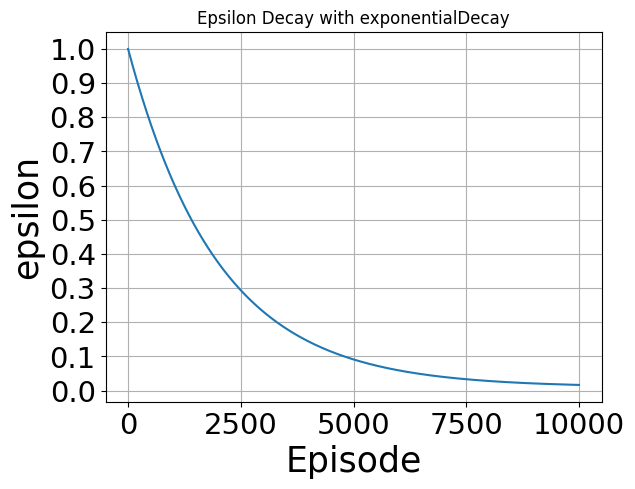

=================Three Action State Env===============

ThreeActionStateEnv init with attributes:
self.seq =  HHPPHH
len(self.seq) =  6
self.obs_output_mode =  tuple
self.state =  OrderedDict([((0, 0), 'H'), ((0, 1), 'H')])
self.actions =  []
self.action_space:
Discrete(3)
self.observation_space:
Box(0, 3, (4,), int64)
self.observation_space.high, low:
[3 3 3 3]
[0 0 0 0]
self.observation_space.shape:
(4,)
self.observation_space.dtype, self.action_space.dtype
int64 int64
self.first_turn_left =  False
initial state/obs:
[0 0 0 0]
n_actions =  3
FCN_QNet insize =  36
FCN_QNet outsize =  3
torch.cuda.is_available() =  True
device =  cuda
NVIDIA A100-SXM4-40GB
Model's state_dict:
fc1.weight 	 torch.Size([256, 36])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([84, 256])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([3, 84])
fc3.bias 	 torch.Size([3])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.0005, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgr

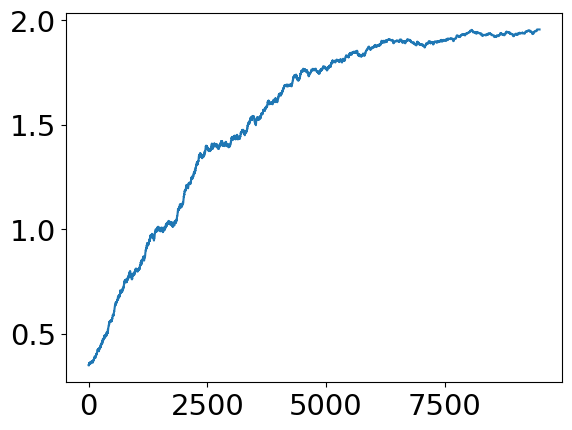

$$$ rewards_all_episodes:  [0. 0. 0. ... 2. 2. 2.]
$$$ rewards_all_episodes last 10 rewards =  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
Frequency of unique rewards of rewards_all_episodes:
[[   0.    1.    2.]
 [1812. 1114. 7074.]]


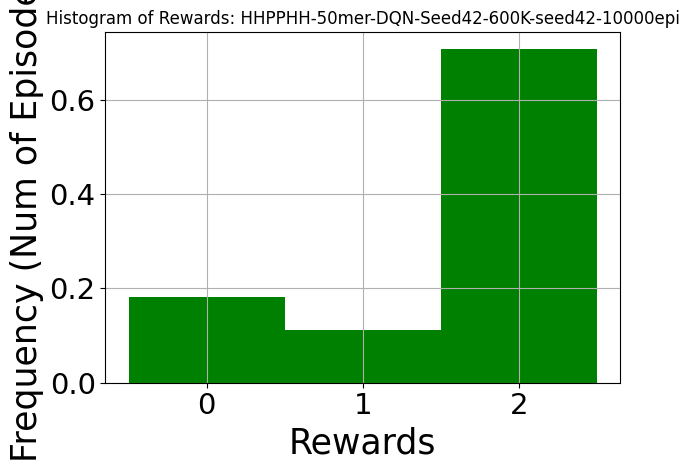

NameError: ignored

In [16]:
# visualize the annealing schedule
Plot_Anneal_Schedule(
    num_episodes,
    min_exploration_rate,
    max_exploration_rate,
    mode=display_mode,
    save_path=save_path,
    warmRestart=warmRestart,
    decay_mode=decay_mode,
    num_restarts=num_restarts,
    exploration_decay_rate=exploration_decay_rate,
    start_decay=start_decay,
)





# Nov30 2021 add one more column of step_E
hp_depth = 2  # {H,P} binary alphabet
action_depth = 4  # 0,1,2,3 in observation_box
energy_depth = 0  # state_E and step_E
# one hot the HP seq
seq_bin_arr = np.asarray([1 if x == 'H' else 0 for x in seq])
seq_one_hot = F.one_hot(torch.from_numpy(seq_bin_arr), num_classes=hp_depth)
seq_one_hot = seq_one_hot.numpy()
# print(f"seq({seq})'s one_hot = ")
# print(seq_one_hot)
init_HP_len = 2  # initial two HP units placed
first_two_actions = np.zeros((init_HP_len,), dtype=int)

def one_hot_state(state_arr, seq_one_hot, action_depth):
                  # state_E_col, step_E_col):
    """
    for NN:
    "one-hot" --> return the one-hot version of the quaternary tuple
    """
    state_arr = np.concatenate((first_two_actions, state_arr))
    # print("after catting first_two_actions, state_arr = ", state_arr, state_arr.dtype, state_arr.shape)
    state_arr = F.one_hot(torch.from_numpy(state_arr), num_classes=action_depth)
    state_arr = state_arr.numpy()  # q.sample_action expects numpy arr
    # print("one-hot first_two_actions catted state = ")
    # print(state_arr)
    state_arr = np.concatenate((
        # state_E_col,
        # step_E_col,
        state_arr,
        seq_one_hot), axis=1)
    # print("state_arr concat with seq_one_hot, state_E_col, step_E_col =")
    # print(state_arr)
    return state_arr

# environment IDs
# env_id="gym_lattice:Lattice2D-4actionStateEnv-v0"
env_id = ":Lattice2D-3actionStateEnv-v0"

if env_id == ":Lattice2D-4actionStateEnv-v0":
    # observation output mode:
    # 1. "tuple"
    # 2. "index_pental"
    # 3. "index_4N3"
    obs_output_mode = "index_4N3"
elif env_id == ":Lattice2D-3actionStateEnv-v0":
    # observation output mode:
    # 1. "tuple"
    # 2. "index_quaternary"
    # 3. "index_3N2"
    obs_output_mode = "tuple"
env_id = "__main__"+env_id
# NOTE: partial_reward Sep15 changed to delta of curr-prev rewards

# env = gym.make(id="gym_lattice:Lattice2D-miranda2020Jul-v1", seq=seq)
env = ThreeActionStateEnv(seq,obs_output_mode)

# reproducible environment and action spaces, do not change lines 6-11 here (tools > settings > editor > show line numbers)
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

# initial state/observation
# NOTE: env.state != state here
# env.state is actually the chain of OrderedDict([((0, 0), 'H')])
# the state here actually refers to the observation!
initial_state = env.reset()

print("initial state/obs:")
print(initial_state)

# Get number of actions from gym action space
n_actions = env.action_space.n
print("n_actions = ", n_actions)

# choice of network for DRL = "FCN_QNet, RNN_LSTM_onlyLastHidden, BRNN..."
network_choice = "FCN_QNet"
row_width = action_depth + hp_depth + energy_depth
col_length = env.observation_space.shape[0] + init_HP_len

if network_choice == "FCN_QNet":
    # FCN_QNet() takes two params: insize and outsize
    # insize ==> input size == size of the observation space
    # insize is flattened obs
    insize = col_length * row_width
    print("FCN_QNet insize = ", insize)
    # outsize ==> output size == number of actions
    print("FCN_QNet outsize = ", n_actions)
    q = FCN_QNet(insize, n_actions).to(device)
    q_target = FCN_QNet(insize, n_actions).to(device)
elif network_choice == "RNN_LSTM_onlyLastHidden":
    # config for RNN
    input_size = row_width
    # number of nodes in the hidden layers
    hidden_size = 256
    num_layers = 2

    print("RNN_LSTM_onlyLastHidden with:")
    print(f"inputs_size={input_size} hidden_size={hidden_size} num_layers={num_layers} num_classes={n_actions}")
    # Initialize network (try out just using simple RNN, or GRU, and then compare with LSTM)
    q = RNN_LSTM_onlyLastHidden(input_size, hidden_size, num_layers, n_actions).to(device)
    q_target = RNN_LSTM_onlyLastHidden(input_size, hidden_size, num_layers, n_actions).to(device)


optimizer = optim.Adam(q.parameters(), lr=learning_rate)

memory = ReplayBuffer(buffer_limit)
# load pre-populated Replay Buffer with good early-stopped and r_max
# TODO: memory.load(f'./xxx.pkl')

# monitor GPU usage
print("torch.cuda.is_available() = ", torch.cuda.is_available())
print("device = ", device)
# Additional Info when using cuda
# https://newbedev.com/how-to-check-if-pytorch-is-using-the-gpu
if device.type == 'cuda':
    # Get the name of the current GPU
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    # print('Memory Usage:')
    # print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    # print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

# Inspect NN state_dict in pytorch
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in q.state_dict():
    print(param_tensor, "\t", q.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

# time the experiment


for n_episode in range(num_episodes):
    # print("\nEpisode: ", n_episode)

    # only render the game every once a while
    if (n_episode == 0) or ((n_episode+1) % show_every == 0):
        if display_mode == "show":
            render = True  # can enable render for debugging
        elif display_mode == "save":
            render = False
    else:
        render = False

    # epsilon = max(min_exploration_rate, max_exploration_rate - exploration_decay_rate*(n_episode/200)) # linear annealing
    if decay_mode == "cosine":
        epsilon = CosineAnnealingSchedule(
            n_episode,
            num_episodes,
            min_exploration_rate,
            max_exploration_rate,
            warmRestart=warmRestart,
            num_restarts=num_restarts,
        )
    elif decay_mode == "exponential":
        epsilon = ExponentialDecay(
            n_episode,
            num_episodes,
            min_exploration_rate,
            max_exploration_rate,
            exploration_decay_rate=exploration_decay_rate,
            start_decay=start_decay,
        )
    elif decay_mode == "linear":
        epsilon = LinearDecay(
            n_episode,
            num_episodes,
            min_exploration_rate,
            max_exploration_rate,
            start_decay=start_decay,
        )

    # reset the environment
    # Initialize the environment and state
    s = env.reset()
    # print("s = ", s, s.dtype, s.shape)
    # print("torch.from_numpy(s) = ", torch.from_numpy(s))

    """
    for NN:
    "one-hot" --> return the one-hot version of the quaternary tuple
    """
    # revert state_E and step_E cols Dec03 2021
    # # column of state_E and column of step_e
    # state_E_col = np.zeros((col_length, 1))
    # step_E_col = np.zeros((col_length, 1))
    s = one_hot_state(s, seq_one_hot, action_depth)
                      # state_E_col, step_E_col)
    # print("one-hot initial_state = ")
    # print(s)

    done = False
    score = 0.0

    # early stopped due to S_B O and E?
    early_stopped = False
    # whether to avoid F in the next step?
    avoid_F = False

    for step in range(max_steps_per_episode):
        # print(f"--- Ep{n_episode} new step-{step}")
        # sample the action from Q
        # convert the given state to torch
        # epsilon is the chance to explore

        # unsqueeze(0) adds a dimension at 0th for batch=1
        # i.e. adds a batch dimension
        a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
        # print('---> action = ', a)

        # take the step and get the returned observation s_prime
        s_prime, r, done, info = env.step(a)
        # print(f"s_prime: {s_prime}, reward: {r}, done: {done}, info: {info}")

        # if do not allow for collision, ie. no collision penalty
        # new_state returned from step() will be None
        while s_prime is None:
            # retry until action is not colliding
            # print("retry sample another action...")
            a = ((a + 1) % 3)
            # print("retried action = ", a)
            # Take the action (a) and observe the outcome state(s') and reward (r)
            s_prime, r, done, info = env.step(a)
            # print(f"s_prime: {s_prime}, reward: {r}, done: {done}, info: {info}")

        # Only keep first turn of Left
        # internal 3actionStateEnv self.last_action updated
        a = env.last_action
        # print("internal 3actionStateEnv last_action = ", a)

        # Sep19 reward returned from Env is a tuple of (state_E, step_E, reward)
        # print("reward tuple = ", r)
        (state_E, step_E, reward) = r
        # print("state_E, step_E, reward = ", state_E, step_E, reward)

        """
        for NN:
            "one-hot" --> return the one-hot version of the quaternary tuple
        """
        # state_E_col[step + init_HP_len] = state_E / OPT_S
        # step_E_col[step + init_HP_len] = step_E / OPT_S
        s_prime = one_hot_state(s_prime, seq_one_hot, action_depth)
                                # state_E_col, step_E_col)
        # print("one-hot s_prime = ")
        # print(s_prime)

        if info["is_trapped"]:
            # print('info["is_trapped"] = ', info["is_trapped"])
            # reward = -(OPT_S - state_E)  # offset by state_E
            # Jan 2022 discover that trap penalty is interfering
            reward = state_E
            # print("adjusted trapped reward = ", reward)


        # NOTE: MUST ENSURE THE REWARD IS FINALIZED BEFORE FEEDING TO RL ALGO!!

        r = reward

        # NOTE: done_mask is for when you get the end of a run,
        # then is no future reward, so we mask it with done_mask
        done_mask = 0.0 if done else 1.0
        # put the sampled state-action-reward-stateAfterwards
        # NOTE: here r is divided by 100.0? Undo the 100.0 Sep04 2021
        # NOTE: priorize experience that are
        # 1. not trapped (r = -1)
        # 2. not early-stopped
        # 3.
        memory.put((s,a,r,s_prime, done_mask))
        s = s_prime

        # Add new reward
        # NOTE: Sep15 update partial_reward to be delta instead of progress*curr_reward
        # NOTE: Sep19 update reward to be a tuple, and reward is 0 until done
        score += r

      
        # clear_output(wait=True)
        # check if the last action ended the episode
        if done:
            # print("Episode finished! Actions: {}".format(info['actions']))
            # if done and used up all actions, pass
            # if done but trapped, zero out the reward
            if len(info['actions']) == (len(seq) - 2):
                # print("Complete: used up all actions!")
                pass
            else:
                if use_early_stop and early_stopped:
                    # print("EARLY STOPPED")
                    num_early_stopped += 1
                else:
                    # otherwise it means the actions result in trapped episode
                    # print("TRAPPED!")
                    num_trapped += 1
            break

    # eventually if memory is big enough, we start running the training loop
    # start training after 2000 (for eg) can get a wider distribution
    # print("memory.size() = ", memory.size())
    if memory.size()>mem_start_train:
        train(q, q_target, memory, optimizer)

    # Update the target network, copying all weights and biases in DQN
    if n_episode % TARGET_UPDATE == 0:
        q_target.load_state_dict(q.state_dict())

    # print("score = ", score)
    # inspect local optima for non-ES spisode scores
    # Add current episode reward to total rewards list
    rewards_all_episodes[n_episode] = score
    # update max reward found so far
    if score > reward_max:
        print("found new highest reward = ", score)
        reward_max = score
        env.render(
            display_mode=display_mode,
            save_fig=save_fig,
            save_path=save_path,
            score=score,
        )

    if (n_episode == 0) or ((n_episode+1) % show_every == 0):
        print("Episode {}, score: {:.1f}, epsilon: {:.2f}, reward_max: {}".format(
            n_episode,
            score,
            epsilon,
            reward_max,
        ))
        print(f"\ts_prime: {s_prime[:3], s_prime.shape}, reward: {r}, done: {done}, info: {info}")
    # move on to the next episode

print('Complete')
# for time records
# Save the ReplayMemory
# TODO: later memory.save(f'{save_path}{config_str}-replaybuffer.pkl')

# Save the pytorch model
# Saving & Loading Model for Inference
# Save/Load state_dict (Recommended)

# ***** plot the stats and save in save_path *****

plot_moving_avg(rewards_all_episodes, mode=display_mode, save_path=save_path)
log_rewards_frequency(rewards_all_episodes)
plot_rewards_histogram(
    rewards_all_episodes,
    mode=display_mode,
    save_path=save_path,
    config_str=config_str,
)
plot_print_rewards_stats(
    rewards_all_episodes,
    show_every,
    mode=display_mode,
    save_path=save_path,
)

env.close()


# # record the performance to a mega stats csv
# with open(f"./HP{len(seq)}-{base_dir}-stats.csv", "a+") as csv_file:
#     stats_writer = csv.writer(
#         csv_file,
#         delimiter=',',
#         quotechar='"',
#         quoting=csv.QUOTE_MINIMAL
#     )
#     stats_writer.writerow([seq, seed, reward_max])
